In [1]:
import pandas as pd
import numpy as np
import scipy
import pickle
import matplotlib
import fitter
import os
import pathlib
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

In [2]:
cwd = os.getcwd()
cwd

'/mnt/EC86AD3086ACFC68/unal/tny/data'

In [3]:
def load_data(csv):
    return pd.read_csv(csv, index_col=0)

In [4]:
def save_list_2_csv(list_, name, path):
    "list_: list to save; name: file name"
    pd.DataFrame({name:list(list_)}).to_csv(os.path.join(path, name+'.csv'))
    # print("--- List was saved as: "+name+".csv")

In [5]:
def time_elements2int(array_):
    for list_ in array_:
        for ii in range(len(list_)):
            if list_[ii] == '00':
                list_[ii] = 0
            elif list_[ii][0] == '0':
                list_[ii] = int(list_[ii][1])
            else:
                list_[ii] = int(list_[ii])
    return array_

In [6]:
def date_elements2int(list_):
    for date in list_:
        date[0] = int(date[0])
        if date[1].startswith("0"):
            date[1] = int(date[1][1])
        else:
            date[1] = int(date[1])
        if date[2].startswith("0"):
            date[2] = int(date[2][1])
        else:
            date[2] = int(date[2])
    return list_

In [7]:
def total_times(do_hour, do_min, do_sec, pu_hour, pu_min, pu_sec):
    assert len(pu_min) == len(do_min)
    range_ = len(pu_min)
    total_times_list = []
    
    for ii in range(range_):
        
        # seconds
        secs_diff = do_sec[ii] - pu_sec[ii]
        if secs_diff < 0:
            secs = secs_diff + 60
        else:
            secs = secs_diff
        
        # minutes
        mins_diff = do_min[ii] - pu_min[ii]
        if mins_diff < 0:
            if secs_diff < 0:
                mins = mins_diff + 59
            else:
                mins = mins_diff + 60
        elif mins_diff > 0: 
            if secs_diff < 0:
                mins = mins_diff - 1
            else:
                mins = mins_diff
        elif mins_diff == 0:
            mins = 0
        
        # hours
        hour_diff = do_hour[ii] - pu_hour[ii]
        if hour_diff < 0:
            if mins_diff < 0:
                hours = hour_diff + 23
            else:
                hours = hour_diff + 24
        elif hour_diff > 0:
            if mins_diff < 0:
                hours = hour_diff - 1
            else:
                hours = hour_diff
        elif hour_diff == 0:
            hours = 0            
    
        total_time = hours*60*60 + mins*60 + secs
        total_times_list.append(total_time)
    return total_times_list

# LOAD

In [8]:
base = load_data("yellow_tripdata_2019-03.csv")
base.columns

/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge'],
      dtype='object')

# PROCESS

In [9]:
base = base[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'trip_distance', 'fare_amount', 'total_amount', 'RatecodeID']]

# datetime -> date, time
base[["pu_date", "pu_time"]] = base["tpep_pickup_datetime"].str.split(" ", expand=True)
base[["do_date", "do_time"]] = base["tpep_dropoff_datetime"].str.split(" ", expand=True)
base = base[['pu_date', 'pu_time', 'do_date', 'do_time', 'trip_distance', 
             'total_amount', 'RatecodeID']]

# date -> year, month, day
base[["pu_year", "pu_month", "pu_day"]] = base["pu_date"].str.split("-", expand=True)
base[["do_year", "do_month", "do_day"]] = base["do_date"].str.split("-", expand=True)
base = base[['pu_year', 'pu_month', 'pu_day', 'pu_time', 'do_year', 'do_month', 
             'do_day', 'do_time','trip_distance', 'total_amount', 'RatecodeID']]

# time -> hour, min, sec
base[['pu_hour', 'pu_min', 'pu_sec']] = base['pu_time'].str.split(":", expand=True)
base[['do_hour', 'do_min', 'do_sec']] = base['do_time'].str.split(":", expand=True)
base = base[['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month',
             'do_day', 'trip_distance', 'total_amount', 'pu_hour',
             'pu_min', 'pu_sec', 'do_hour', 'do_min', 'do_sec', 'RatecodeID']]

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'pu_hour', 'pu_min', 'pu_sec',
       'do_hour', 'do_min', 'do_sec', 'RatecodeID'],
      dtype='object')

In [10]:
# times str to int

times = {'pu_hour':list(base.pu_hour), 'pu_min':list(base.pu_min), 
         'pu_sec':list(base.pu_sec), 'do_hour':list(base.do_hour), 
         'do_min':list(base.do_min), 'do_sec':list(base.do_sec)}

for ii in range(len(base)):
    # pu
    if times["pu_hour"][ii][0]=="0":
        times["pu_hour"][ii] = int(times["pu_hour"][ii][1])
    else:
        times["pu_hour"][ii] = int(times["pu_hour"][ii])
    
    if times["pu_min"][ii][0]=="0":
        times["pu_min"][ii] = int(times["pu_min"][ii][1])
    else:
        times["pu_min"][ii] = int(times["pu_min"][ii])
    
    if times["pu_sec"][ii][0]=="0":
        times["pu_sec"][ii] = int(times["pu_sec"][ii][1])
    else:
        times["pu_sec"][ii] = int(times["pu_sec"][ii])
        
    # do
    if times["do_hour"][ii][0]=="0":
        times["do_hour"][ii] = int(times["do_hour"][ii][1])
    else:
        times["do_hour"][ii] = int(times["do_hour"][ii])
    
    if times["do_min"][ii][0]=="0":
        times["do_min"][ii] = int(times["do_min"][ii][1])
    else:
        times["do_min"][ii] = int(times["do_min"][ii])
    
    if times["do_sec"][ii][0]=="0":
        times["do_sec"][ii] = int(times["do_sec"][ii][1])
    else:
        times["do_sec"][ii] = int(times["do_sec"][ii])
        
drop_list = ['pu_hour', 'pu_min', 'pu_sec', 'do_hour', 
                         'do_min', 'do_sec']

base = base.drop(columns=drop_list)

for col in drop_list:
    base[col] = times[col]

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'RatecodeID', 'pu_hour', 'pu_min',
       'pu_sec', 'do_hour', 'do_min', 'do_sec'],
      dtype='object')

In [11]:
trip_times = total_times(list(base["do_hour"]), list(base["do_min"]), 
                         list(base["do_sec"]), list(base["pu_hour"]), 
                         list(base["pu_min"]), list(base["pu_sec"]))

base["trip_time"] = trip_times

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'RatecodeID', 'pu_hour', 'pu_min',
       'pu_sec', 'do_hour', 'do_min', 'do_sec', 'trip_time'],
      dtype='object')

# GENERAL CLEANING

In [12]:
base = base[(base.trip_distance<201) & (base.trip_distance>0.05)]
base = base[(base.total_amount<650) & (base.total_amount>0.5)]
base = base[(base.pu_year=="2019") & (base.do_year=="2019")]
base = base[(base.pu_month=="03") & (base.do_month=="03")]
base = base[(base.trip_time<8999) & (base.trip_time>59)]

In [13]:
base.sort_values(by=["trip_time"], ascending=False).head()

,pu_year,pu_month,pu_day,do_year,do_month,do_day,trip_distance,total_amount,RatecodeID,pu_hour,pu_min,pu_sec,do_hour,do_min,do_sec,trip_time
VendorID,,,,,,,,,,,,,,,,
2,2019,03,09,2019,03,09,28.11,112.80,1,8,2,59,10,32,54,8995
2,2019,03,24,2019,03,24,6.21,25.80,1,9,56,55,12,26,45,8990
1,2019,03,16,2019,03,16,21.10,86.06,2,15,15,3,17,44,30,8967
2,2019,03,02,2019,03,02,18.34,61.80,1,18,53,2,21,22,18,8956
2,2019,03,22,2019,03,23,8.20,36.56,1,21,31,3,0,0,0,8937


In [14]:
base.to_csv("march_2019.csv")

# FILTERING

## BY DAY

In [15]:
fridays = ['01', '08', '15', '22', '29']
saturdays = ['02', '09', '16', '23', '30']
sundays = ['03', '10', '17', '24', '31']
mondays = ['04', '11', '18', '25']
tuesdays = ['05', '12', '19', '26']
wednesdays = ['06', '13', '20', '27']
thursdays = ['07', '14', '21', '28']

In [16]:
monday = base[(base.pu_day==mondays[0])]
tuesday = base[(base.pu_day==tuesdays[0])]
wednesday = base[(base.pu_day==wednesdays[0])]
thursday = base[(base.pu_day==thursdays[0])]
friday = base[(base.pu_day==fridays[0])]
saturday = base[(base.pu_day==saturdays[0])]
sunday = base[(base.pu_day==sundays[0])]

In [16]:
days_list = [friday, saturday, sunday, monday, tuesday, wednesday, thursday]

In [5]:
days_names_list = ['friday', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday']

In [18]:
del base

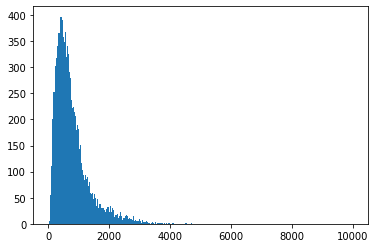

In [19]:
monday8 = monday[monday["pu_hour"]==8]
monday8l = list(monday8["trip_time"])

plt.hist(monday8l, bins=300, range=(0,10000),density=False)
plt.show()

### SAVING

#### DISTANCES BY DAY

dist_dir = cwd+"/output/distances/"
pathlib.Path(cwd+dist_dir).mkdir(parents=True, exist_ok=True)

m_distances = list(monday.trip_distance)
save_list_2_csv(m_distances, "monday_distances", dist_dir)

tu_distances = list(tuesday.trip_distance)
save_list_2_csv(tu_distances, "tuesday_distances", dist_dir)

we_distances = list(wednesday.trip_distance)
save_list_2_csv(we_distances, "wednesday_distances", dist_dir)

th_distances = list(thursday.trip_distance)
save_list_2_csv(th_distances, "thursday_distances", dist_dir)

fr_distances = list(friday.trip_distance)
save_list_2_csv(fr_distances, "friday_distances", dist_dir)

sa_distances = list(saturday.trip_distance)
save_list_2_csv(sa_distances, "saturday_distances", dist_dir)

su_distances = list(sunday.trip_distance)
save_list_2_csv(su_distances, "sunday_distances", dist_dir)

plt.hist(m_distances, bins=300, range=(0,30), density=True)
plt.show()

#### MONEY BY DAY

money_dir = cwd+"/output/money/"
pathlib.Path(money_dir).mkdir(parents=True, exist_ok=True)

m_fares = list(monday.total_amount)
save_list_2_csv(m_fares, "monday_fares", money_dir)

tu_fares = list(tuesday.total_amount)
save_list_2_csv(tu_fares, "tuesday_fares", money_dir)

we_fares = list(wednesday.total_amount)
save_list_2_csv(we_fares, "wednesday_fares", money_dir)

th_fares = list(thursday.total_amount)
save_list_2_csv(th_fares, "thursday_fares", money_dir)

fr_fares = list(friday.total_amount)
save_list_2_csv(fr_fares, "friday_fares", money_dir)

sa_fares = list(saturday.total_amount)
save_list_2_csv(sa_fares, "saturday_fares", money_dir)

su_fares = list(sunday.total_amount)
save_list_2_csv(su_fares, "sunday_fares", money_dir)

plt.hist(m_fares, bins=300, range=(0,100), density=True)
plt.show

## BY TIME OF DAY

In [20]:
interest_cols = ["total_amount", "trip_time", "trip_distance"]
col = interest_cols[0]
for day, day_name in zip(days_list, days_names_list):
    day_dir = cwd+"/output/"+col+"/"+day_name
    day_dir_f = cwd+"/output/"+col+"_filtered/"+day_name
    pathlib.Path(day_dir).mkdir(parents=True, exist_ok=True)
    pathlib.Path(day_dir_f).mkdir(parents=True, exist_ok=True)
    for hour in range(24):
        
        day_ = day.copy()
        day_hour = day_[(day_.pu_hour==hour)]
        day_hour_list = list(day_hour[col])
        save_list_2_csv(day_hour_list, str(hour)+"_"+col, day_dir)
        
        day_f = day.copy()
        day_f = day_f[day_f.RatecodeID==1]
        day_hour_f = day_f[(day_f.pu_hour==hour)]
        day_hour_f_list = list(day_hour_f[col])
        save_list_2_csv(day_hour_f_list, str(hour)+"_"+col , day_dir_f)

#### TESTING

In [8]:
a = pd.read_csv("output/trip_distance_filtered/friday/0_trip_distance.csv", index_col=0)
a = np.array(a["0_trip_distance"]).reshape(-1,1)
a = a/max(a)

f = fitter.Fitter(a, distributions=["norm", "uniform"], bins=100)
f.fit()
errors_dict = f.df_errors.to_dict()["sumsquare_error"]
params_dict = f.fitted_param

results_dict = {"dist":[], "params":[], "sumsqr_error":[]}

for dist_name, error in errors_dict.items():

    results_dict["dist"].append(dist_name)
    results_dict["params"].append(params_dict[dist_name])
    results_dict["sumsqr_error"].append(error)
    
results_dict

Fitted norm distribution with error=210.31035192011208)
Fitted uniform distribution with error=442.79009528429197)


{'dist': ['norm', 'uniform'],
 'params': [(0.11050728839918812, 0.1110034062491713),
  (0.002033898305084746, 0.9979661016949153)],
 'sumsqr_error': [210.31035192011208, 442.79009528429197]}

# Fitting

In [39]:
def fit_results(file, dir_, dist_list, bins=300):
    
    name = file[:-4]
    data = pd.read_csv(dir_+file, index_col=0)
    data = np.array(data[name]).reshape(-1,1)
    data = data
    len_ = len(data)
    
    f = fitter.Fitter(data, 
                      distributions=dist_list,
                      bins = bins,
                      timeout = 800)
    
    f.fit()
    errors_dict = f.df_errors.to_dict()["sumsquare_error"]
    params_dict = f.fitted_param
    
    results_dict = {"dist":[], "params":[], "sumsqr_error":[]}
    
    for dist_name, error in errors_dict.items():
        results_dict["dist"].append(dist_name)
        results_dict["params"].append(params_dict[dist_name])
        results_dict["sumsqr_error"].append(error)
        
    return results_dict

In [40]:
fitcualquiera = fit_results("17_trip_distance.csv", "output/trip_distance_filtered/friday/", ["lognorm"], bins=20) 

Fitted lognorm distribution with error=0.007523085656177923)


In [41]:
fitcualquiera

{'dist': ['lognorm'],
 'params': [(0.8573534360880989, 0.06856626867968758, 1.4964707425212445)],
 'sumsqr_error': [0.007523085656177923]}

In [12]:
dist_list = ["burr", "burr12", "fatiguelife", "frechet_r", "frechet_l",
             "johnsonsb", "johnsonsu", "lognorm", "pearson3"]

big_results = {"day":[], "hour":[], "dist":[], "params":[], "sumsqr_error":[]}

for day in days_names_list:
    
    dir_ = "output/trip_distance_filtered/"+day+"/"
    
    for subdir, dirs, files in sorted(os.walk(dir_)):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                name = file[:-4]
                
                results = fit_results(file, dir_, dist_list)
                
                for ii in range(len(results["dist"])):
                    big_results["dist"].append(results["dist"][ii])
                    big_results["params"].append(results["params"][ii])
                    big_results["sumsqr_error"].append(results["sumsqr_error"][ii])
                    big_results["day"].append(day)
                    big_results["hour"].append(name)
            
big_results_df = pd.DataFrame(big_results)

with open('distances_fit.pickle', 'wb') as handle:
    pickle.dump(big_results, handle)

/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted burr distribution with error=29.86858532329206)
Fitted burr12 distribution with error=50.1928932725332)
Fitted fatiguelife distribution with error=33.43780006556194)
Fitted frechet_r distribution with error=219.78405837287048)
Fitted frechet_l distribution with error=315.0820877315034)
Fitted johnsonsb distribution with error=33.250867822023466)
Fitted johnsonsu distribution with error=20.173539742306588)
Fitted lognorm distribution with error=30.706489087599554)
Fitted pearson3 distribution with error=162.31727188499144)
Fitted burr distribution with error=13.368312628705233)
Fitted burr12 distribution with error=305.16304623881103)
Fitted fatiguelife distribution with error=160.4596377066971)
Fitted frechet_r distribution with error=644.1660727270857)
Fitted frechet_l distribution with error=1027.0728835149396)
Fitted johnsonsb distribution with error=974.6009734285982)
Fitted johnsonsu distribution with error=27.618645640965855)
Fitted lognorm distribution with error=92.36107

In [13]:
dist_list = ["burr", "burr12", "fatiguelife", "frechet_r", "frechet_l",
             "johnsonsb", "johnsonsu", "lognorm", "pearson3"]

big_results = {"day":[], "hour":[], "dist":[], "params":[], "sumsqr_error":[]}

for day in days_names_list:
    
    dir_ = "output/total_amount_filtered/"+day+"/"
    
    for subdir, dirs, files in sorted(os.walk(dir_)):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                name = file[:-4]
                
                results = fit_results(file, dir_, dist_list)
                
                for ii in range(len(results["dist"])):
                    big_results["dist"].append(results["dist"][ii])
                    big_results["params"].append(results["params"][ii])
                    big_results["sumsqr_error"].append(results["sumsqr_error"][ii])
                    big_results["day"].append(day)
                    big_results["hour"].append(name)
            
big_results_df = pd.DataFrame(big_results)

with open('money_fit.pickle', 'wb') as handle:
    pickle.dump(big_results, handle)

Fitted burr distribution with error=355.4071181400415)
Fitted burr12 distribution with error=345.19780350771407)
Fitted fatiguelife distribution with error=399.0451666654162)
Fitted frechet_r distribution with error=583.2097605127241)
Fitted frechet_l distribution with error=521.3991225887751)
Fitted johnsonsb distribution with error=385.9712123943037)
Fitted johnsonsu distribution with error=344.5112641041396)
Fitted lognorm distribution with error=385.1403500673757)
Fitted pearson3 distribution with error=486.21805732943153)
Fitted burr distribution with error=397.61987005527817)
Fitted burr12 distribution with error=403.7801812818427)
Fitted fatiguelife distribution with error=440.30565522169746)
Fitted frechet_r distribution with error=616.4249512148485)
Fitted frechet_l distribution with error=483.0573233972546)
Fitted johnsonsb distribution with error=422.82107943555036)
Fitted johnsonsu distribution with error=400.200954003291)
Fitted lognorm distribution with error=422.53902137

In [9]:
dist_list = ["burr", "burr12", "fatiguelife", "frechet_r", "frechet_l",
             "johnsonsb", "johnsonsu", "lognorm", "pearson3"]

big_results = {"day":[], "hour":[], "dist":[], "params":[], "sumsqr_error":[]}

for day in days_names_list:
    
    try:
    
        dir_ = "output/trip_time_filtered/"+day+"/"

        for subdir, dirs, files in sorted(os.walk(dir_)):
            for file in files:
                filepath = subdir + os.sep + file
                if filepath.endswith(".csv"):
                    name = file[:-4]

                    results = fit_results(file, dir_, dist_list)

                    for ii in range(len(results["dist"])):
                        big_results["dist"].append(results["dist"][ii])
                        big_results["params"].append(results["params"][ii])
                        big_results["sumsqr_error"].append(results["sumsqr_error"][ii])
                        big_results["day"].append(day)
                        big_results["hour"].append(name)
            
    except FileNotFoundError:
        pass
        
big_results_df = pd.DataFrame(big_results)

with open('time_fit.pickle', 'wb') as handle:
    pickle.dump(big_results, handle)

/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted burr distribution with error=30.189429914147397)
Fitted burr12 distribution with error=23.488074177218824)
Fitted fatiguelife distribution with error=15.812381248214567)
Fitted frechet_r distribution with error=38.44204457279654)
Fitted frechet_l distribution with error=69.84522205961544)
Fitted johnsonsb distribution with error=15.657025904137214)
Fitted johnsonsu distribution with error=18.257974667381426)
Fitted lognorm distribution with error=18.226120476823567)
Fitted pearson3 distribution with error=22.422996495320614)
Fitted burr distribution with error=20.92936194991856)
Fitted burr12 distribution with error=12.277940593267308)
Fitted fatiguelife distribution with error=11.898168286835304)
Fitted frechet_r distribution with error=21.532264598833297)
Fitted frechet_l distribution with error=46.12443085712878)
Fitted johnsonsb distribution with error=10.570102983128722)
Fitted johnsonsu distribution with error=15.346352373023107)
Fitted lognorm distribution with error=15.3

/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1880: RuntimeWarning: overflow encountered in power
  return np.log(c) + sc.xlogy(c-1, -x) - pow(-x, c)
/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Fitted frechet_l distribution with error=135.62538742348787)
Fitted johnsonsb distribution with error=20.586204034322165)
Fitted johnsonsu distribution with error=19.43097896272797)
Fitted lognorm distribution with error=20.387517130116645)
Fitted pearson3 distribution with error=79.70801256471898)
Fitted burr distribution with error=8.348401121295465)
Fitted burr12 distribution with error=7.8769871387239325)
Fitted fatiguelife distribution with error=21.320150549053015)
Fitted frechet_r distribution with error=106.54347197432118)
Fitted frechet_l distribution with error=85.1743216596607)
Fitted johnsonsb distribution with error=12.86311593009089)
Fitted johnsonsu distribution with error=11.431246319430894)
Fitted lognorm distribution with error=11.519533800423776)
Fitted pearson3 distribution with error=49.74692704044586)
Fitted burr distribution with error=16.150167792345865)
Fitted burr12 distribution with error=10.340666853386045)
Fitted fatiguelife distribution with error=9.922262

In [23]:
with open('distances_fit.pickle', 'rb') as handle:
    distances_fit = pickle.load(handle)

In [25]:
distances_fit_df = pd.DataFrame(distances_fit)

In [26]:
distances_fit_df[]

,day,hour,dist,params,sumsqr_error
0,friday,0_trip_distance,burr,"(1.7778622935970216, 11.778282903078779, -0.01...",29.868585
1,friday,0_trip_distance,burr12,"(1.8734879055521902, 1.0240160668424951, 0.001...",50.192893
2,friday,0_trip_distance,fatiguelife,"(0.9365396705645791, -0.0012862133551842137, 0...",33.437800
3,friday,0_trip_distance,frechet_l,"(261380288.94765323, 15775880.573998798, 15775...",315.082088
4,friday,0_trip_distance,frechet_r,"(1.1200028982326655, 0.002029329612467879, 0.1...",219.784058
...,...,...,...,...,...
1507,thursday,9_trip_distance,frechet_r,"(1.0538622583935235, 0.0021342483702737553, 0....",601.567062
1508,thursday,9_trip_distance,johnsonsb,"(1.478706300061929, 0.597702176959928, 0.00210...",889.893258
1509,thursday,9_trip_distance,johnsonsu,"(-1.9996684808818255, 0.9096530691883411, 0.01...",78.560490
1510,thursday,9_trip_distance,lognorm,"(0.8741803466307794, 0.001681852058418252, 0.0...",115.730809


In [27]:
distances_fit_df.to_csv("distances_fit.csv")

In [19]:
selected = money_fit_df[money_fit_df["hour"]=="0_total_amount"]

In [21]:
selected = selected[selected["dist"]=="burr"]

In [22]:
selected

,day,hour,dist,params,sumsqr_error
0,friday,0_total_amount,burr,"(2.968220622308165, 22.364454968809913, -0.019...",355.407118
216,saturday,0_total_amount,burr,"(3.321418780326818, 8.641253405534457, -0.0234...",455.972750
432,sunday,0_total_amount,burr,"(3.1790897537331206, 3.58553064513789, 0.00252...",200.138430
648,monday,0_total_amount,burr,"(2.2097533744915028, 11.36742887275621, 0.0049...",133.501366
864,tuesday,0_total_amount,burr,"(2.668199414248088, 20.61102156458211, -0.0170...",345.127328
1080,wednesday,0_total_amount,burr,"(3.1220950715319873, 34.97164039104655, -0.023...",379.923173
1296,thursday,0_total_amount,burr,"(2.981212886633931, 33.508583800652744, -0.022...",399.748025
